# Richardson-Lucy deconvolution: unfolding the spectrum

In the previous tutorial we injected an analytic spectrum (a power law) and fitted it with the same model. That looks like cheating, but sometimes we do have goods reasons to believe that the source spectrum will indeed have approximately certain shape, so a "modeled search" is justified. We however don't want to be restricted only to modeled searches since our spectrum might might have some interesting feature that can go missing.    

As a way to illustrate this, let's inject a "weird" spectrum composed by two power laws, one and low energies and one at high energy, joined at the peak energy of 1 MeV:

In [ ]:
MultiComponentSpectrum(weights)

here


array([0.00609565, 0.00880812, 0.01272758, 0.01839113, 0.02657486,
       0.03840022, 0.05548765, 0.0801787 , 0.11355045, 0.10985378,
       0.09138685, 0.07602429, 0.06324425, 0.05261259, 0.04376817,
       0.03641053, 0.03028975, 0.0251979 , 0.02096201, 0.0174382 ,
       0.01450676, 0.0120681 , 0.0100394 , 0.00835173, 0.00694776,
       0.00577981, 0.0048082 , 0.00399992, 0.00332751, 0.00276814])

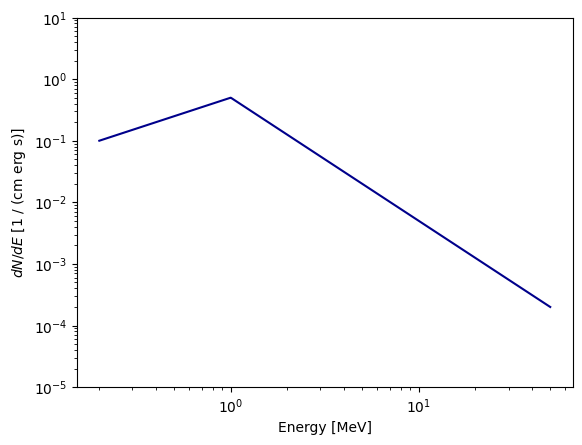

In [11]:
from gammaraytoys.detectors.source import Spectrum
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from gammaraytoys.detectors import PowerLawSpectrum, PointSource

class MultiComponentSpectrum(Spectrum):
    
    def __init__(self, *components, weights = None):
        
        if weights is None:
            self.weights = np.ones(len(components))
        else:
            self.weights = np.array(weights, dtype = float)
            
        self.weights /= np.sum(self.weights)
            
        self.components = components
        
        self._min_energy = np.min(u.Quantity([c.min_energy for c in components]))
        self._max_energy = np.max(u.Quantity([c.max_energy for c in components]))
        
    def ncomponents(self):
        return len(self.components)
        
    @property
    def min_energy(self):
        return self._min_energy

    @property
    def max_energy(self):
        return self._max_energy

    def random_energy(self, size = None):

        component_idx = np.random.choice(self.ncomponents, size = size, p = self.weights)
        
        energies = []
        
        for ncomponent in range(self.ncomponents):
            
            nsamples = np.sum(component_idx == ncomponent)
            
            energies.append(self.components[component_idx].random_energy(size = nsamples))
            
        energies = u.Quantity(np.shuffle(energies))
        
        return energies

    def pdf(self, energy):

        prob = u.Quantity([w*c.pdf(energy) for c,w in zip(self.components, self.weights)])
        
        prob = np.sum(prob, axis = None if np.ndim(energy) == 0 else 0)
        
        return prob

    def cdf(self, energy):

        cdf = [w*c.cdf(energy) for c,w in zip(self.components, self.weights)]
        
        cdf = np.sum(cdf, axis = None if np.ndim(energy) == 0 else 0)
        
        return cdf
   
component1 = PowerLawSpectrum(index = 1, min_energy = 200*u.keV, max_energy = 1*u.MeV)
component2 = PowerLawSpectrum(index = -2, min_energy = 1*u.MeV, max_energy = 50*u.MeV)

smulti = MultiComponentSpectrum(component1,component2, 
                                weights = [1,component1.pdf(1*u.MeV)/component2.pdf(1*u.MeV)])

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = smulti,
                     flux_pivot = 1/u.erg/u.cm/u.s,
                     pivot_energy = 1*u.MeV)

source.plot_spectrum(e2 = False, label = 'Real spectrum', color = 'darkblue');

#smulti.cdf(50*u.MeV)

from gammaraytoys.analysis import SpectralResponse
response = SpectralResponse.open("instrument_response/response_energy_onaxis_traddet.h5")

#source.discretize_spectrum(response.axes['Ei'])

print('here')
smulti.integrate(response.axes['Ei'].lower_bounds, response.axes['Ei'].upper_bounds)

In [2]:
(1/u.erg/u.cm/u.s)/smulti.pdf(1*u.MeV)

<Quantity 730. keV / (cm erg s)>

In [4]:
source.diff_flux(1*u.MeV).to(1/u.erg/u.cm/u.s)

<Quantity 1. 1 / (cm erg s)>

/Users/israel/work/cosi/software/gammaraytoys/gammaraytoys/detectors/source.py:288: RuntimeWarning: divide by zero encountered in log10
  ax.set_ylim(10**(np.floor(np.log10(np.array(np.min(y))))-1),
/Users/israel/work/cosi/software/gammaraytoys/gammaraytoys/detectors/source.py:288: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(10**(np.floor(np.log10(np.array(np.min(y))))-1),


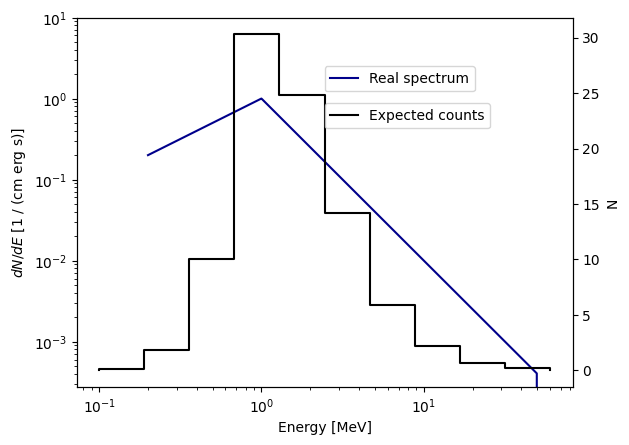

In [1]:
# Imports
from gammaraytoys.detectors import PowerLawSpectrum, PointSource, MultiComponentSpectrum
from gammaraytoys.analysis import SpectralResponse
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from histpy import Histogram

# Observation duration
duration = 1*u.day

# Spectrum. Two components that are matched at 1 MeV
# Note: I used .99999*u.MeV for the weights because the PDF range is 
# closed on the left and open on the right i.e. [min_energy, max_energy)
component1 = PowerLawSpectrum(index = 1,  min_energy = 200*u.keV, max_energy = 1*u.MeV)
component2 = PowerLawSpectrum(index = -2, min_energy = 1*u.MeV,   max_energy = 50*u.MeV)

smulti = MultiComponentSpectrum(component1,component2, 
                                weights = [1,component1.pdf(.99999*u.MeV)/component2.pdf(1*u.MeV)])

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = smulti,
                     flux_pivot = 1/u.erg/u.cm/u.s,
                     pivot_energy = 1*u.MeV)

# Convolve with the response
response = SpectralResponse.open("instrument_response/response_energy_onaxis_traddet.h5")

expected_signal_counts = response.expected_counts(source, duration)

# ==== Plots ====
fig,axl = plt.subplots()

# Real spectrum on the left axis
source.plot_spectrum(axl, e2 = False, label = 'Real spectrum', color = 'darkblue');
axl.legend(loc = (.5,.8))

# Observed 
axr = axl.twinx()
expected_signal_counts.plot(axr, color = 'black', label = 'Expected counts')
axr.set_ylabel("N")
axr.legend(loc = (.5,.7))

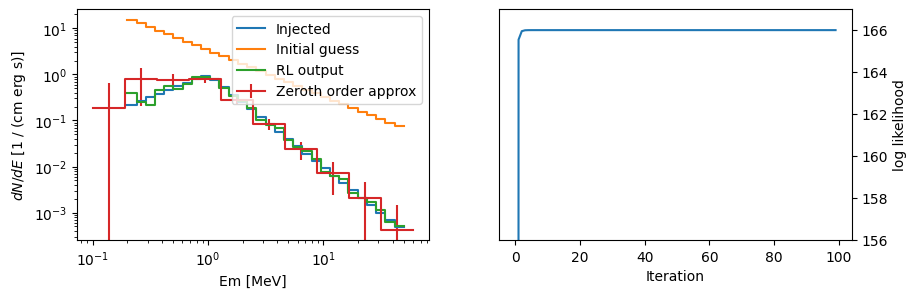

In [14]:
from copy import copy, deepcopy
from gammaraytoys.analysis import poisson_binned_log_likelihood

data = deepcopy(expected_signal_counts)

# See exercise below
# data[:] = np.random.poisson(data.contents)

approx_flux = Histogram(data.axis, data.contents, sumw2 = data.contents)
approx_flux /= duration # Per time
approx_flux /= response.effective_area().interp(data.axis.centers) # Per area

model_0 = Histogram(response.axes['Ei'], unit = 1/u.cm/u.s)
model_0[:] = 1e-6/u.cm/u.s # Doesn't matter much
                    
# Bare contents
model = deepcopy(model_0)
R_ij = response.contents.transpose() * duration
R_j = response.effective_area().contents * duration
M_j = model.contents
N_i = data.contents

log_like = []

niter = 100
for t in range(niter):

    expectation = np.dot(R_ij, M_j)

    log_like.append(poisson_binned_log_likelihood(data, expectation))

    # nansum skips cases where both data and expectation are 0
    coeff = np.nansum((N_i/expectation)[:,None] * R_ij, axis = 0)
                      
    # Similar here. Handle R_j = 0
    norm_coeff = np.zeros_like(coeff)
    np.divide(coeff, R_j, out = norm_coeff,
              where = (coeff!=0) | (R_j != 0))
    
    M_j *= norm_coeff

model[:] = M_j


fig,axes = plt.subplots(figsize = [10,3], ncols = 2)
ax = axes[0]

#source.plot_spectrum(ax, e2 = True, label = 'Spectrum');
#source2.plot_spectrum(ax, e2 = True, label = 'Spectrum');

spec_binned = source.discretize_spectrum(response.axes['Ei'])
#spec2_binned = source2.discretize_spectrum(response.axes['Ei'])

spect_tot_binned = spec_binned#+spec2_binned

# To density and units
y_units = u.Unit(1/u.erg/u.cm/u.s)
spect_tot_binned_density = (spect_tot_binned/spect_tot_binned.axis.widths).to(y_units)
model_0_density = (model_0/model_0.axis.widths).to(y_units)
model_density = (model/model.axis.widths).to(y_units)
approx_flux_density = (approx_flux/approx_flux.axis.widths).to(y_units)

spect_tot_binned_density.plot(ax, label = "Injected")
model_0_density.plot(ax, label = "Initial guess")
model_density.plot(ax, label = "RL output")
approx_flux_density.plot(ax, label = "Zeroth order approx", errorbars = True)

ax.set_yscale('log')

ax.set_ylabel(f'$dN/dE$ [{y_units}]')

#(approx_flux*approx_flux.axis.centers**2/approx_flux.axis.widths).to(u.erg/u.cm/u.s).plot(ax)
#(model_0*model_0.axis.centers**2/model_0.axis.widths).to(u.erg/u.cm/u.s).plot(ax, label = "Initial guess")
#(model*model.axis.centers**2/model.axis.widths).to(u.erg/u.cm/u.s).plot(ax, label = "RL output")

ax.legend(loc = 'upper right')

ax = axes[1]
ax.plot(log_like)
ax.set_ylim(np.max(log_like) - 10, np.max(log_like)+1)
ax.set_ylabel('log likelihood')
ax.set_xlabel('Iteration')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

Converged quickly. Simple case
Observed break in the spectrum. Do not fit it directly (no errors). Do a forward folding instead. 

Ex: try different number of iteration
Excersize: Poisson data. Shot noise and artifacts, specially low exposure (small effective area). No errors.

## bkg and nuisance